# 워드 임베딩 실습 (한국어 금융 텍스트) — 단일 노트북
**목표**
- 한국어 금융 데이터셋의 `SRC` 열에서 약 2,000개를 추출해 임베딩 실습
- **Word2Vec**(CBOW/Skip-gram)과 **FastText**를 직접 학습
- (선택) **사전학습(pretrained)** 모델 불러와 비교
- **유사도·아날로지**, **t-SNE 시각화** 수행
- (보너스) 간단한 **문장 임베딩**으로 유사 문장 탐색

> 권장: **Google Colab**에서 실행 (GPU 불필요)

## 1) 환경 준비

In [1]:
# 필수 라이브러리 확인 및 설치 (Colab 호환 안정 버전)
import sys, subprocess, pkgutil

def pip_install(pkgs):
    """패키지 설치 함수"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs])
    except Exception as e:
        print("pip 설치 중 오류:", e)

# 기본 필수 패키지 목록
base_pkgs = ["pandas", "numpy", "gensim", "scikit-learn", "matplotlib"]

# Hugging Face datasets 및 konlpy 포함
extra_pkgs = ["datasets", "konlpy"]

need = []
for p in base_pkgs + extra_pkgs:
    if pkgutil.find_loader(p) is None:
        need.append(p)

# NumPy 버전 불일치 방지: datasets는 numpy<2.0 환경에서 안정
install_cmd = [
    "numpy<2.0",
    "pandas<2.2.3",
    "pyarrow<17",
    "datasets>=2.17,<2.21",
    "gensim",
    "scikit-learn",
    "matplotlib",
    "konlpy"
]

if need:
    print("설치 필요:", need)
    pip_install(install_cmd)

# konlpy 확인
try:
    import konlpy  # noqa
    print("konlpy 사용 가능")
except Exception:
    print("konlpy 미설치. 필요한 경우 `!pip install konlpy` 후 런타임 재시작 필요")


/tmp/ipython-input-3894164793.py:19: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader(p) is None:


설치 필요: ['scikit-learn']
konlpy 사용 가능


## 2) 데이터 불러오기 및 2,000개 샘플링

In [2]:
# Hugging Face에서 korfin-asc-test 로드 → SRC N개 샘플링
# - 데이터셋이 공개라면 토큰 불필요
# - split 이름이 다를 수 있어 첫 split 자동 선택 처리

!pip -q install datasets

from datasets import load_dataset
import pandas as pd

# 1) 데이터셋 로드 (필요 시 데이터셋 ID만 바꿔주세요)
DATASET_ID = "amphora/korfin-asc-test"  # 예: "amphora/korfin-asc-test"
ds = load_dataset(DATASET_ID)

# 2) split 선택 (train이 있으면 train 사용, 없으면 첫 번째 split)
split_name = "train" if "train" in ds else list(ds.keys())[0]
print(f"사용 split: {split_name}")

df = ds[split_name].to_pandas()

# 3) SRC 컬럼 확인
assert "SRC" in df.columns, f"'SRC' 컬럼이 없습니다. 현재 컬럼: {list(df.columns)}"

# 4) 기본 정제: 결측/공백 제거
df = df.dropna(subset=["SRC"]).copy()
df = df[df["SRC"].astype(str).str.strip().astype(bool)]

# 5) 최대 2,000개 샘플링
SAMPLE_N = 2000
sample_df = df.sample(min(SAMPLE_N, len(df)), random_state=42).reset_index(drop=True)

print(sample_df.head())
print(f"\n실습에 사용되는 행 수: {len(sample_df)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


사용 split: train
      SID          TYPE                                                SRC  \
0  1802_0  MULTIPLE_ENT  하나은행은 지난해 하반기 중 예대금리차가 가장 크게 축소되었던 두 은행(하나금융과 ...   
1  2309_0    SINGLE_ENT  3분기 마케팅 비용 감소에 따라 영업이익은 전 분기 대비 11.9% 증가 3분기 S...   
2  3651_1  MULTIPLE_ENT  3분기 매출액은 이러닝 서비스 부문 전년 동기 대비 6.1% 감소하였으나 OPIc부...   
3  1855_0    SINGLE_ENT  9월에도 진세조선의 선박 1척의 보험금을 지급할 예정이며 전체 금액은 약 $ 59m...   
4  1492_0    SINGLE_ENT  현재 한국타이어의 주가 수준은 여전히 비싼 국면으로 판단되어 투자의견 Underpe...   

   ASPECT SENTIMENT  
0    하나은행  POSITIVE  
1   SK텔레콤  NEGATIVE  
2  OPIc부문  POSITIVE  
3    진세조선   NEUTRAL  
4   한국타이어  NEGATIVE  

실습에 사용되는 행 수: 2000


## 3) 라이트 전처리 (숫자/백분율/날짜 치환)

In [3]:
# 금융 텍스트의 숫자/비율/날짜를 특수 토큰으로 치환
import re

num_pat = re.compile(r"\b[+-]?\d{1,3}(?:[,\d]{0,3})*(?:\.\d+)?\b")
pct_pat = re.compile(r"\b[+-]?\d+(?:\.\d+)?\s*%")
date_pat = re.compile(r"\b(?:\d{4}[./-]\d{1,2}[./-]\d{1,2}|\d{1,2}[./-]\d{1,2})\b")

def normalize_text(s: str) -> str:
    s = re.sub(pct_pat, "<PERCENT>", s)
    s = re.sub(num_pat, "<AMOUNT>", s)
    s = re.sub(date_pat, "<DATE>", s)
    return s

sample_df["SRC_norm"] = sample_df["SRC"].astype(str).map(normalize_text)
sample_df[["SRC","SRC_norm"]].head(10)

,SRC,SRC_norm
0,하나은행은 지난해 하반기 중 예대금리차가 가장 크게 축소되었던 두 은행(하나금융과 ...,하나은행은 지난해 하반기 중 예대금리차가 가장 크게 축소되었던 두 은행(하나금융과 ...
1,3분기 마케팅 비용 감소에 따라 영업이익은 전 분기 대비 11.9% 증가 3분기 S...,3분기 마케팅 비용 감소에 따라 영업이익은 전 분기 대비 <PERCENT> 증가 3...
2,3분기 매출액은 이러닝 서비스 부문 전년 동기 대비 6.1% 감소하였으나 OPIc부...,3분기 매출액은 이러닝 서비스 부문 전년 동기 대비 <PERCENT> 감소하였으나 ...
3,9월에도 진세조선의 선박 1척의 보험금을 지급할 예정이며 전체 금액은 약 $ 59m...,9월에도 진세조선의 선박 1척의 보험금을 지급할 예정이며 전체 금액은 약 $ 59m...
4,현재 한국타이어의 주가 수준은 여전히 비싼 국면으로 판단되어 투자의견 Underpe...,현재 한국타이어의 주가 수준은 여전히 비싼 국면으로 판단되어 투자의견 Underpe...
5,"통상 신규 브랜드는 런칭 후 2년 정도 경과되면 BEP에 도달하게 되는데, 한화의 ...","통상 신규 브랜드는 런칭 후 2년 정도 경과되면 BEP에 도달하게 되는데, 한화의 ..."
6,"한편 LG전자는 현재 중국 텐진에서 삼성전자 휴대폰 EMS를 하고 있으며, 향후에는...","한편 LG전자는 현재 중국 텐진에서 삼성전자 휴대폰 EMS를 하고 있으며, 향후에는..."
7,"두산중공업의 출자액은 1, 2차 자본금 141.6백만 유로와 SPC의 2011년까지...","두산중공업의 출자액은 <AMOUNT>, 2차 자본금 <AMOUNT>.6백만 유로와 ..."
8,당사는 대림산업의 하반기 유화사업부 실적이 크게 우려할 만한 수준은 아니라고 판단한다.,당사는 대림산업의 하반기 유화사업부 실적이 크게 우려할 만한 수준은 아니라고 판단한다.
9,태광SCT 3Q 실적은 시장 기대치 크게 못 미칠 전망 3분기 실적은 FnGuide...,태광SCT 3Q 실적은 시장 기대치 크게 못 미칠 전망 3분기 실적은 FnGuide...


## 4) 토큰화 (Okt 우선, 실패 시 정규식 분할)

In [4]:
# konlpy.Okt가 있으면 (명사 + 동사)만 추출, 없으면 정규식 분할로 대체
def tokenize_korean(texts):
    try:
        from konlpy.tag import Okt
        okt = Okt()
        result = []
        for t in texts:
            pos = okt.pos(t, stem=True)  # 어근화(stem=True)로 동사 원형 유지
            tokens = [word for word, tag in pos if tag in ["Noun", "Verb"]]
            result.append(tokens)
        return result
    except Exception:
        import re
        tok = re.compile(r"[^\w]+", re.UNICODE)
        return [[w for w in tok.split(t) if w] for t in texts]

tokenized = tokenize_korean(sample_df["SRC_norm"].tolist())
print("토큰화 예시 3건:", tokenized[:3])

토큰화 예시 3건: [['하나은행', '지난해', '하반기', '중', '금리', '가장', '크게', '축소', '되어다', '두', '은행', '하나', '금융', '외환은행', '중', '하나로', '올해', '하반기', '마진', '개선', '효과', '행', '대비', '가장', '크다', '수'], ['마케팅', '비용', '감소', '따르다', '영업', '이익', '전', '분기', '대비', '증가', '텔레콤', '영업', '수익', '전', '분기', '대비', '감소', '하다'], ['매출', '액', '이러닝', '서비스', '부문', '년', '동기', '대비', '감소', '하다', '부문', '증가', '기록', '함', '따르다', '년', '동기', '증가', '하다']]


## 5) Word2Vec 학습 (CBOW vs Skip-gram)

In [5]:
from gensim.models import Word2Vec

# 공통 하이퍼파라미터
params = dict(vector_size=100, window=5, min_count=2, workers=4)

# CBOW(sg=0), Skip-gram(sg=1)
w2v_cbow = Word2Vec(sentences=tokenized, sg=0, **params)
w2v_sg   = Word2Vec(sentences=tokenized, sg=1, **params)

print("CBOW 단어수:", len(w2v_cbow.wv))
print("SG   단어수:", len(w2v_sg.wv))

CBOW 단어수: 2708
SG   단어수: 2708


## 6) FastText 학습

In [6]:
from gensim.models import FastText

ft = FastText(sentences=tokenized, vector_size=100, window=5, min_count=2, workers=4)
print("FastText 단어수:", len(ft.wv))

FastText 단어수: 2708


## 7) 유틸 함수: 유사도·아날로지·프로빙

In [8]:

def _as_kv(m):
    """Word2Vec/FastText(model.wv) 또는 KeyedVectors 둘 다를 KeyedVectors로 통일"""
    return m.wv if hasattr(m, "wv") else m

import pandas as pd
from typing import List

def safe_most_similar(model, word, topn=10):
    kv = _as_kv(model)
    if word not in kv.key_to_index:
        return [(f"(OOV: {word})", 0.0)]
    return kv.most_similar(word, topn=topn)

def probe_words(models: dict, words: List[str], topn=5):
    rows = []
    for w in words:
        row = {"단어": w}
        for name, m in models.items():
            try:
                res = safe_most_similar(m, w, topn=topn)[:3]
                row[name] = ", ".join([f"{a}:{s:.2f}" for a, s in res])
            except Exception as e:
                row[name] = f"(err:{type(e).__name__})"
        rows.append(row)
    return pd.DataFrame(rows)

def analogy(model, a, b, c, topn=5):
    kv = _as_kv(model)
    try:
        return kv.most_similar(positive=[a, c], negative=[b], topn=topn)
    except KeyError:
        pos = [x for x in [a, c] if x in kv.key_to_index]
        neg = [x for x in [b] if x in kv.key_to_index]
        if not pos:
            return [("N/A (OOV)", 0.0)]
        try:
            return kv.most_similar(positive=pos, negative=neg, topn=topn)
        except Exception:
            return [("N/A", 0.0)]


## 8) 금융 용어 빠른 점검 (프로빙)

In [9]:
terms = ["금리","주가","환율","채권","ETF","부채비율","삼성전자","은행","증권","자동차"]

models = {
    "w2v_cbow": w2v_cbow,
    "w2v_sg": w2v_sg,
    "fasttext": ft
}

probe_df = probe_words(models, terms, topn=5)
probe_df

,단어,w2v_cbow,w2v_sg,fasttext
0,금리,"한솔:1.00, 제품:1.00, 향후:1.00","점진:1.00, 할인:1.00, 변경:1.00","하나로텔레콤:1.00, 물량:1.00, 등:1.00"
1,주가,"투자:1.00, 원:1.00, 조정:1.00","목표:0.99, 유지:0.98, 의견:0.98","투자:1.00, 조정:1.00, 제시:1.00"
2,환율,"이:1.00, 관련:1.00, 경우:1.00","요인:0.99, 역시:0.99, 도:0.99","따르다:1.00, 떨어지다:1.00, 되어다:1.00"
3,채권,"해양:0.98, 간판:0.98, 여건:0.98","석:1.00, 불안:1.00, 금:1.00","추세:1.00, 휴대폰:1.00, 인도:1.00"
4,ETF,(OOV: ETF):0.00,(OOV: ETF):0.00,(OOV: ETF):0.00
5,부채비율,(OOV: 부채비율):0.00,(OOV: 부채비율):0.00,(OOV: 부채비율):0.00
6,삼성전자,(OOV: 삼성전자):0.00,(OOV: 삼성전자):0.00,(OOV: 삼성전자):0.00
7,은행,"경쟁:1.00, 시장:1.00, 늘다:1.00","산정:0.99, 주:0.99, 타이어:0.99","되어다:1.00, 시장:1.00, 등:1.00"
8,증권,"및:1.00, 설비:1.00, 기업:1.00","시한:0.99, 수익률:0.99, 티엘아이:0.99","대우인터내셔널:1.00, 금융:1.00, 최근:1.00"
9,자동차,"향후:1.00, 계약:1.00, 등:1.00","보안:0.99, 수출:0.99, 전방:0.99","등:1.00, 제품:1.00, 경쟁:1.00"


## 9) (선택) 사전학습 임베딩 불러오기

In [10]:
# 한국어 FastText 텍스트(.vec) 다운로드
!wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.vec.gz
!gunzip -f cc.ko.300.vec.gz

from gensim.models import KeyedVectors

# ✅ 유니코드 깨짐 무시 + 상위 N 토큰만 로드(용량/시간 절약)
ft_pre = KeyedVectors.load_word2vec_format(
    "cc.ko.300.vec",
    binary=False,
    unicode_errors="ignore",   # ← 디코딩 이슈 회피
    limit=200_000              # ← 필요에 따라 100k/300k로 조절
)

# 기존 비교 딕셔너리에 추가
models["ft_pretrained_ko_subset"] = ft_pre
print("Loaded tokens:", len(ft_pre))
print(ft_pre.most_similar("은행")[:10])


Loaded tokens: 200000
[('은행의', 0.6722247004508972), ('금융', 0.6294413805007935), ('뱅킹', 0.6137771010398865), ('금융기관', 0.6099650263786316), ('은행이', 0.6086292266845703), ('은행인', 0.6017679572105408), ('은행을', 0.5958477258682251), ('예금', 0.5893162488937378), ('은행은', 0.5853719115257263), ('은행들의', 0.58265620470047)]


## 10) 학습 모델 vs 사전학습 모델 비교

In [11]:
# 위 셀에서 ft_pre를 로드했다면 모델 사전에 추가

if len(models) > 3:
    probe_df2 = probe_words(models, ["금리","주가","환율","은행","증권"], topn=3)
    display(probe_df2)
else:
    print("사전학습 모델이 로드되지 않았습니다. 비교 생략.")

,단어,w2v_cbow,w2v_sg,fasttext,ft_pretrained_ko_subset
0,금리,"한솔:1.00, 제품:1.00, 향후:1.00","점진:1.00, 할인:1.00, 변경:1.00","하나로텔레콤:1.00, 물량:1.00, 등:1.00","금리가:0.68, 기준금리:0.65, 대출금리:0.62"
1,주가,"투자:1.00, 원:1.00, 조정:1.00","목표:0.99, 유지:0.98, 의견:0.98","투자:1.00, 조정:1.00, 제시:1.00","주와:0.53, 주를:0.53, 주들이:0.47"
2,환율,"이:1.00, 관련:1.00, 경우:1.00","요인:0.99, 역시:0.99, 도:0.99","따르다:1.00, 떨어지다:1.00, 되어다:1.00","환율과:0.61, 환율이:0.59, 원달러:0.59"
3,은행,"경쟁:1.00, 시장:1.00, 늘다:1.00","산정:0.99, 주:0.99, 타이어:0.99","되어다:1.00, 시장:1.00, 등:1.00","은행의:0.67, 금융:0.63, 뱅킹:0.61"
4,증권,"및:1.00, 설비:1.00, 기업:1.00","시한:0.99, 수익률:0.99, 티엘아이:0.99","대우인터내셔널:1.00, 금융:1.00, 최근:1.00","금융:0.65, 증시:0.57, 은행:0.55"


## 11) t-SNE 시각화

In [12]:
# ✅ Matplotlib 한글 폰트 설정 (Colab/리눅스/윈도우/맥 공용)
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import os, sys, subprocess

def _install_font_if_needed():
    # 1) Colab/리눅스: 나눔고딕 설치
    if sys.platform.startswith("linux"):
        try:
            subprocess.check_call(["bash","-lc","apt-get update -qq && apt-get install -y fonts-nanum > /dev/null 2>&1"])
        except Exception:
            pass

    # 2) 폰트 경로 후보
    candidates = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",         # Linux (fonts-nanum)
        "/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf",
        "/System/Library/Fonts/AppleSDGothicNeo.ttc",               # macOS
        "C:/Windows/Fonts/malgun.ttf",                              # Windows (맑은 고딕)
        "C:/Windows/Fonts/NGULIM.TTF",
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

font_path = _install_font_if_needed()

# 3) 폰트 적용
if font_path and os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    font_name = fm.FontProperties(fname=font_path).get_name()
    matplotlib.rcParams["font.family"] = font_name
else:
    # 폰트가 없으면 DejaVuSans에 한글 fallback이 없어서 여전히 깨질 수 있음
    print("한글 폰트 파일을 찾지 못했습니다. Colab이라면 위 apt 설치 로그를 확인하세요.")

# 4) 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

print("사용 폰트:", matplotlib.rcParams["font.family"])


사용 폰트: ['NanumGothic']


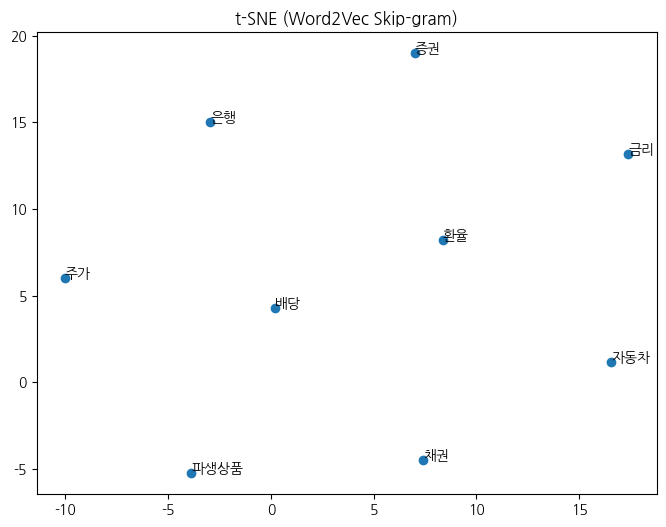

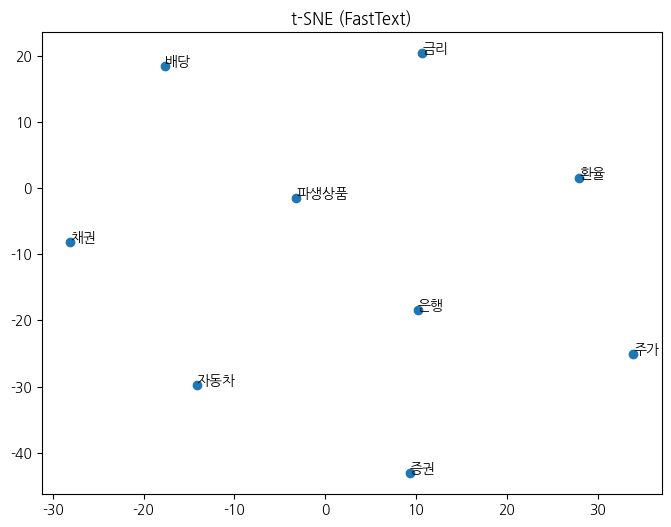

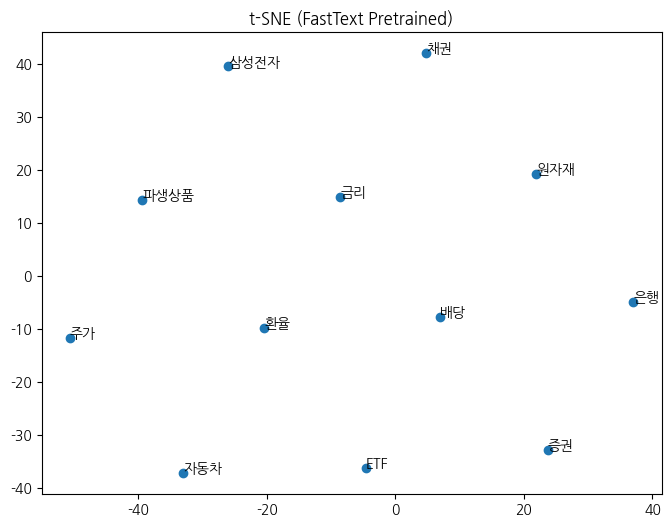

In [13]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from typing import List

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from typing import List

def _as_kv(m):
    return m.wv if hasattr(m, "wv") else m

def tsne_plot(model, pick_words: List[str], title: str):
    kv = _as_kv(model)
    words, vecs = [], []
    for w in pick_words:
        if w in kv.key_to_index:
            words.append(w); vecs.append(kv[w])
    if not vecs:
        print("표시할 단어가 없습니다.")
        return
    vecs = np.array(vecs)
    perplexity = max(5, min(30, len(vecs)-1))
    tsne = TSNE(n_components=2, random_state=0, init="random", perplexity=perplexity)
    reduced = tsne.fit_transform(vecs)

    plt.figure(figsize=(8,6))
    plt.scatter(reduced[:,0], reduced[:,1])
    for i, w in enumerate(words):
        plt.annotate(w, (reduced[i,0], reduced[i,1]))
    plt.title(title)
    plt.show()

pick = ["금리","주가","환율","채권","ETF","삼성전자","자동차","은행","증권","원자재","배당","파생상품"]

tsne_plot(w2v_sg, pick, "t-SNE (Word2Vec Skip-gram)")
tsne_plot(ft, pick, "t-SNE (FastText)")

# 사전학습 모델이 있으면 추가로 시각화
try:
    tsne_plot(ft_pre, pick, "t-SNE (FastText Pretrained)")
except NameError:
    pass

## 12) 아날로지 데모

In [14]:
print("아날로지 예시: '도쿄 - 일본 + 한국 ≈ ?'")
try:
    print("w2v_sg:", analogy(w2v_sg, "도쿄","일본","한국")[:5])
except Exception as e:
    print("w2v_sg 불가:", e)
try:
    print("fasttext:", analogy(ft, "도쿄","일본","한국")[:5])
except Exception as e:
    print("fasttext 불가:", e)

# 사전학습 모델이 있으면 비교
try:
    print("ft_pre:", analogy(ft_pre, "도쿄","일본","한국")[:5])
except NameError:
    pass

아날로지 예시: '도쿄 - 일본 + 한국 ≈ ?'
w2v_sg: [('하향', 0.7165951728820801), ('유지', 0.7153215408325195), ('상향', 0.7106420993804932), ('조정', 0.6961895823478699), ('목표', 0.690653920173645)]
fasttext: [('분리', 0.2663183808326721), ('확', 0.23467639088630676), ('반지', 0.22708159685134888), ('격차', 0.22503256797790527), ('만날', 0.22462385892868042)]
ft_pre: [('서울', 0.5465582609176636), ('뉴욕', 0.4630035161972046), ('런던', 0.4257733225822449), ('파리', 0.41877079010009766), ('LA', 0.4120205044746399)]


## 13) (보너스) 문장 임베딩(평균) + 근접 문장 탐색

In [15]:
# 단어 임베딩 평균으로 문장 임베딩을 만들고, 코사인 거리 기반 최근접 문장 탐색
import numpy as np
from sklearn.neighbors import NearestNeighbors

def sentence_vector(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

sent_tokens = tokenized[:200]  # 데모용 소규모
sent_matrix = np.vstack([sentence_vector(t, w2v_sg) for t in sent_tokens])
nbrs = NearestNeighbors(n_neighbors=5, metric="cosine").fit(sent_matrix)

idx = 0
print("쿼리 문장:", sample_df.iloc[idx]["SRC"])
dists, inds = nbrs.kneighbors([sent_matrix[idx]])
for rank, i in enumerate(inds[0]):
    print(f"#{rank}: {sample_df.iloc[i]['SRC'][:100]} ... (cos dist={dists[0][rank]:.3f})")

쿼리 문장: 하나은행은 지난해 하반기 중 예대금리차가 가장 크게 축소되었던 두 은행(하나금융과 외환은행) 중 하나로서 올해 하반기 마진 개선 효과는 타행대비 가장 클 수 밖에 없다.
#0: 하나은행은 지난해 하반기 중 예대금리차가 가장 크게 축소되었던 두 은행(하나금융과 외환은행) 중 하나로서 올해 하반기 마진 개선 효과는 타행대비 가장 클 수 밖에 없다. ... (cos dist=0.000)
#1: 또한 홈플러스의 높은 영업잠재력을 감안하면 그동안 이마트가 누려오던 대형마트 업계 내 독보적인 시장지위는 다소 약화될 수 있다는 판단이다. ... (cos dist=0.002)
#2: 코오롱의 투자포인트는 1) 기존 사업부(산업자재, 필름, 화학 )의 고른 실적 개선이 예상되고, 2) 아라미드, 광학용 필름 등을 통한 추가적인 성장이 기대되며, 3) 실적 개선, ... (cos dist=0.003)
#3: 향후 경기 여건 변화에 따라서 다시 타은행보다 대손 부담이 더 크게 늘어날 개연성은 있지만 당분간은 광주은행의 자산건전성이 다시 크게 악화될 여지는 높지 않다고 판단된다. ... (cos dist=0.004)
#4: 현대차 그룹의 성장성 흡수에 대한 모멘텀은 여전히 유효. 성우하이텍의 2009년 실적은 전반적인 자동차 산업의 침체로 감소가 불가피할 전망이다. ... (cos dist=0.004)


## 14) 모델 저장

In [ ]:
w2v_cbow.save("w2v_cbow_korfin.model")
w2v_sg.save("w2v_sg_korfin.model")
ft.save("fasttext_korfin.model")
print("저장 완료: w2v_cbow_korfin.model, w2v_sg_korfin.model, fasttext_korfin.model")